В данном блокноте продемонстрируем некоторые методы сегментирования изображений.

Начнем с метода водораздела (Watershed Segmentation), а затем продемонстрируем применение глубоких нейросетевых архитектур к задаче сегментирования изображений.

Для начала установим необходимые бибилиотеки

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import colorsys
import argparse
import imutils
import random
import os
import sys
from google.colab.patches import cv2_imshow

Загружаем изображение и применяем pyramid mean shift filter — функцию в OpenCV, что уменьшает количество цветов. Далее переводим изображение в градации серого (метод водораздела работает с монохромной цветовой гаммой). 

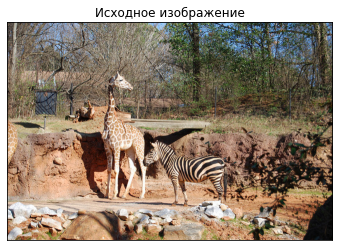

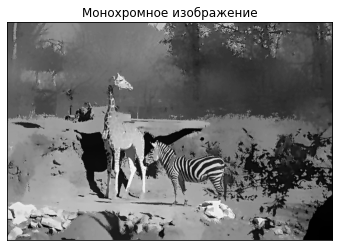

In [ ]:
img = cv2.imread('/content/coffee.jpg')
img = cv2.imread('/content/task.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.show()
shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, 'gray')
plt.title('Монохромное изображение'), plt.xticks([]), plt.yticks([])
plt.show()

Для получения хорошего результата, необходимо проделать ряд манипуляций.

Применим метод Оцу, который использует гистограмму изображения для расчета порога отсечения, позволяющего разделить наше изображение на светлые и темные объекты.

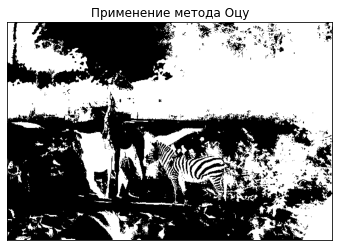

In [ ]:
thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
plt.imshow(thresh, 'gray')
plt.title('Применение метода Оцу'), plt.xticks([]), plt.yticks([])
plt.show()

Проведем ряд простых морфологических операций: уберем шум

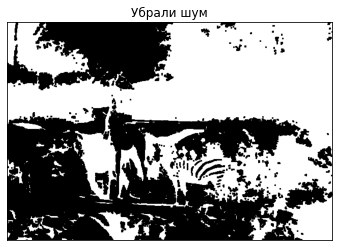

In [ ]:
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE, np.ones((2,2),np.uint8), iterations = 2)
plt.imshow(closing, 'gray')
plt.title('Убрали шум'), plt.xticks([]), plt.yticks([])
plt.show()

Если разница двух последних результатов не заметна, увеличьте размер выводимых изображений.

Размоем фон с помощью функции dilate, а далее применим
Distance transform — значение каждого пикселя заменяется на его расстоянием до ближайшего пикселя фона. 

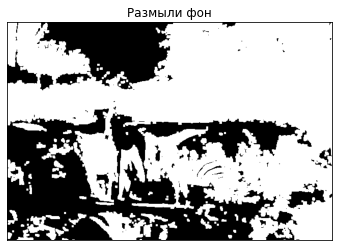

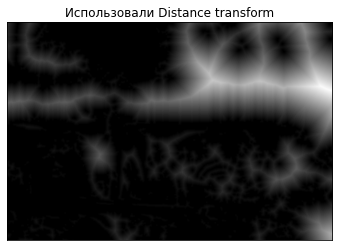

In [ ]:
sure_bg = cv2.dilate(closing,np.ones((2,2),np.uint8),iterations=3)
plt.imshow(sure_bg, 'gray')
plt.title('Размыли фон'), plt.xticks([]), plt.yticks([])
plt.show()
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
plt.imshow(dist_transform, 'gray')
plt.title('Использовали Distance transform'), plt.xticks([]), plt.yticks([])
plt.show()

Выполняем пороговое преобразование для получения пиков. Это будут маркеры для объектов переднего плана.

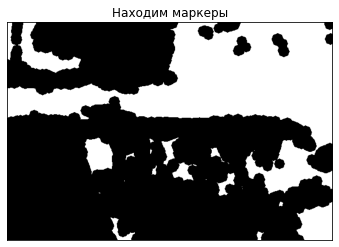

In [ ]:
sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)[1]
sure_fg = np.uint8(sure_fg)
plt.imshow(sure_fg, 'gray')
plt.title("Находим маркеры"), plt.xticks([]), plt.yticks([])
plt.show()

На данный момент у нас есть пики и фон. Вычитая из размытого изображения пики, получаем область, которая не определена.

Области, в которых мы уверены, обозначаем разными положительными целыми числами, а неопределенную область обозначаем 0. Для этого используем функцию cv2.connectedComponents(). Эта функция присваивает фону значение 0, а нефоновым объектам присваивает целые значения, начиная с единицы.

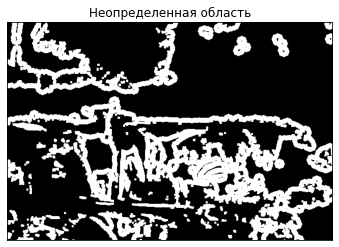

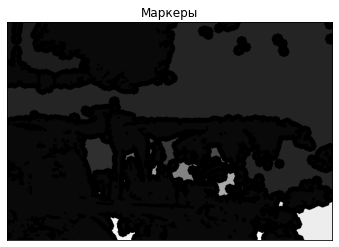

In [ ]:
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown, 'gray')
plt.title("Неопределенная область"), plt.xticks([]), plt.yticks([])
plt.show()
markers = cv2.connectedComponents(sure_fg)[1]
markers = markers+1 # прибавляем 1, чтобы избежать 0 в областях, которые определены
markers[unknown==255] = 0
plt.imshow(markers, 'gray')
plt.title("Маркеры"), plt.xticks([]), plt.yticks([])
plt.show()

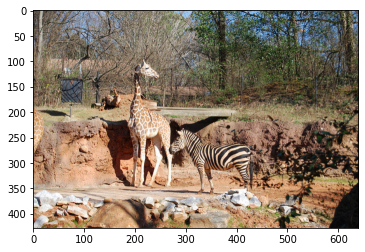

In [ ]:
plt.imshow(img)

А теперь применим функцию водораздела, границам маркеров будет присвоено значение -1. На исходном изображении эти пиксели окрасим в синий цвет.

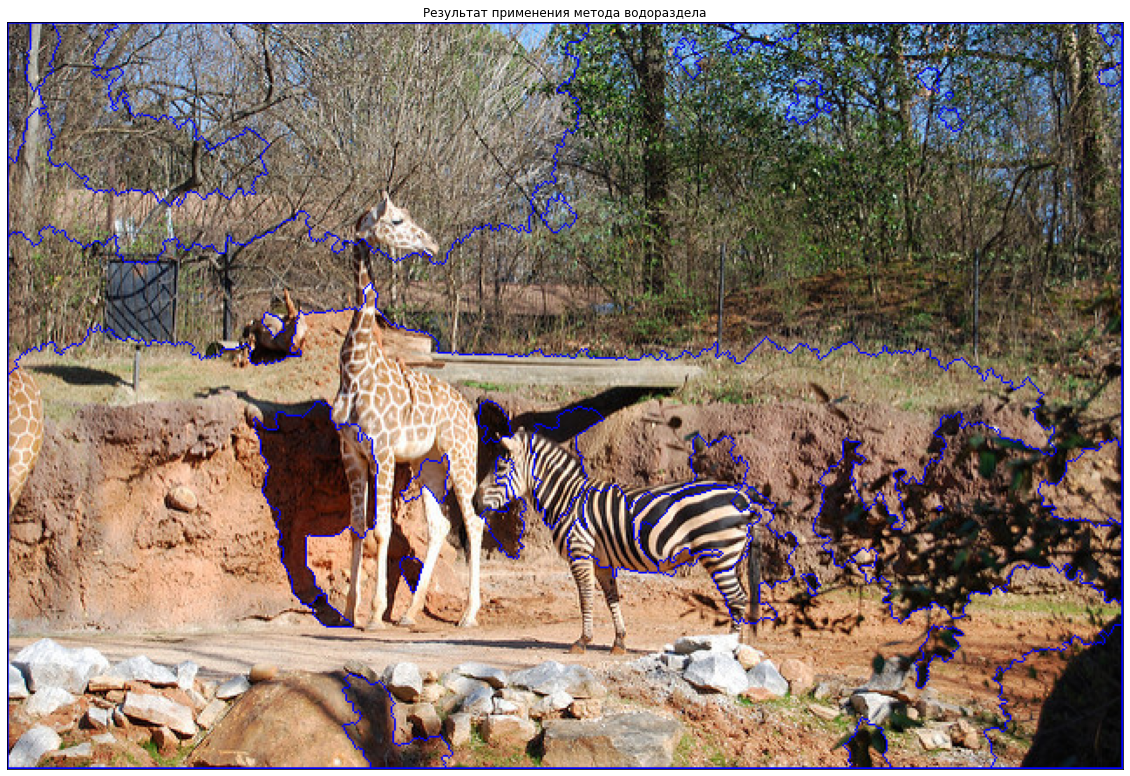

In [ ]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [0,0,255]
fig = plt.figure(figsize=(20,20))
plt.imshow(img)
plt.title("Результат применения метода водораздела"), plt.xticks([]), plt.yticks([])
plt.show()


In [ ]:
n_rows, n_cols, _ = img.shape
n_markers = markers[markers == -1].size

In [ ]:
# доля границы
n_markers / (n_rows * n_cols)

0.027460572429906543

In [ ]:
# доля фона
markers[markers == 1].size / (n_rows * n_cols)

0.5495436623831775

In [ ]:
# доля переднего плана
1.0 - 0.027 - 0.550

0.42299999999999993